In [21]:
%load_ext autoreload
%autoreload 

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

import shared.query as q
import shared.viz as viz

from scipy import sparse
from sklearn.metrics import pairwise_distances

viz.set_style()
conn = q.connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recommendations

This worksheet explores the inner workings of Presto! - transforming reviews into recommendations

In [32]:
## Settings

max_product_pool_size = 10
max_user_pool_size = 20
fill_value = 0
category = 'Music'
title = 'The Pleasure Principle'


In [33]:
product = q.find_products(category, search_term = title, conn = conn).loc[0]
product

find_products: 14 results in 16.568 seconds


id                                                     B000006NTW
reviews                                                        80
title                                      The Pleasure Principle
creator                                                Gary Numan
publisher                                                        
description     Digitally remastered! Debut 1979 solo album, r...
release_date                                       April 30, 2006
category                                                    Music
subcategory                                                      
Name: 0, dtype: object

In [34]:
title_font_size = 15
subtitle_font_size = 12
colorbar_font_size = 15
axis_font_size = 13
subtitle_color = ('k', 0.66)

def highlight_active_product(axis, data, product_id):
    labels = axis.get_ticklabels()
    product_idx = list(data.index).index(product_id)
    if product_idx != None:
        target_label = labels[product_idx]
        target_label.set_fontweight('bold')

def add_title_and_subtitle(ax, title, subtitle):
    title_text = ax.set_title(title, fontsize = title_font_size, loc = 'left', pad = 32)
    #subtitle_text = ax.text(0, 1, subtitle, fontsize = subtitle_font_size, color = subtitle_color)
    subtitle_text = ax.annotate(
        subtitle, 
        xy = (0,1), xycoords = 'axes fraction', verticalalignment = 'bottom', 
        xytext = (0, 14), textcoords = 'offset points',
        fontsize = subtitle_font_size, color = subtitle_color
    )
    return title_text, subtitle_text

def plot_user_ratings_by_product(
        data: pd.DataFrame, 
        target_product_id: str, # to highlight the active / target product 
        conn, 
        cbar_kws = None,
        product_name_limit = 20,
        hide_y_axis_cutoff = 50,
        hide_x_axis_cutoff = 500
):    
    cmap = mpl.colormaps.get_cmap('Blues')
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # create heatmap
    result = sns.heatmap(data, vmin = 0, vmax = 5, cmap = cmap, norm = norm, cbar_kws = cbar_kws)

    # customize rating colorbar
    colorbar = result.collections[0].colorbar
    colorbar.set_label("Rating", fontsize = colorbar_font_size)
    colorbar.set_ticks(range(0,6))
    colorbar.set_ticklabels(['None', '★', '★★', '★★★', '★★★★', '★★★★★'], fontsize = 15)
    colorbar.outline.set_visible(True)
    colorbar.outline.set_color('k')
    for spine in ['top', 'bottom', 'left', 'right']:
        colorbar.ax.spines[spine].set_visible(True)
        result.spines[spine].set_visible(True)

    # customize main chart
    product_names = q.get_product_details(data.index, conn = conn, select = 'title')['title']
    product_names = product_names.map(lambda title: title[:product_name_limit])
    result.yaxis.set_ticklabels(product_names.values, fontsize = axis_font_size)
    result.yaxis.label.set_visible(False)
    plt.xlabel('User', fontsize = axis_font_size, labelpad = 12)
    txt = result.xaxis.set_label_text('User', fontsize = axis_font_size, horizontalalignment = 'left', x = 0)
    #txt.set_position((1, 1))
    result.xaxis.set_ticklabels([f'U{i+1}' for i in range(len(data.columns))], fontsize = axis_font_size)
    add_title_and_subtitle(result, 'User Ratings Per Product', 'Rows are ratings by individual users')
    
    highlight_active_product(result.yaxis, data, target_product_id)

    if data.shape[1] >= hide_x_axis_cutoff:    
        result.xaxis.set_visible(False)
    if data.shape[0] >= hide_y_axis_cutoff:
        result.yaxis.set_visible(False)
    
    return result

#plot_user_ratings_by_product(user_ratings_per_product, product.id, conn)


## Get Related Reviews

Get books that have reviewers in common with this book:

In [35]:
reviews = q.get_reviews(product.id, conn)
related_reviews = q.get_related_reviews(reviews, conn, filter_unhelpful_reviews = True, max_reviewer_count = max_user_pool_size, max_product_count = max_product_pool_size)
related_reviews[:2]

get_reviews: 80 results in 0.033 seconds
0.0377: Got 3531 related reviews of 3274 products by 80 users
0.0417: Filtered 51 related reviews by user and/or product


,user_id,product_id,rating,upvotes,downvotes
55,AECFQOZKAJ7O2HGAEFPU74YAP5HQ,B000002GYI,5,4,0
56,AECFQOZKAJ7O2HGAEFPU74YAP5HQ,B000002GZ4,3,4,0


## Compute Cosine Similarities

### Create Rating Table of products by reviewers

In [36]:
user_ratings_per_product = pd.pivot(
    related_reviews,
    values = 'rating',
    index = 'product_id',
    columns = 'user_id'
)
user_ratings_per_product.fillna('')

user_id,AECFQOZKAJ7O2HGAEFPU74YAP5HQ,AF4NADS7QTIYHSQZQ33MBMEPYYXQ,AF75VSMGAX4XPYZVWIVPZI4JIIIQ,AFAWQJAG45W2BOQFTYWI3HOTMRWQ,AFDPKO7LALFIGDQ3JTUMMIB6O4PA,AFSHTYBUE763W7XYWLD3AIQ73ZLA,AFVTL45JTUQTHK56IYHHVUXFKFQQ,AFYHLKGGAQDHNGM5H4ML43WU36KQ,AGAKV2IAD5E3UE336W2LNQDLAV4Q,AGD4XT4QXBSLMXLMK5XMPERX6RZA,AGDL3UCOMT5XSUUKG3LTAMWJYBAQ,AGENBTR33AZRFFTATRZ6QMOBDV5A,AGFJGSV3ZT55GYTTP5I5SUUJWM7Q,AGQ7A3WCFBUPHUDCBRXOULQSUI7Q,AGYCVIK3SVOSMQUAVYHKPWG73MAA,AH3F4AYI762FO274ARPOOMBXOCLA,AHJ3S3V3XBCJZFF7EE4RALKBJPPQ,AHRMC6WMY67TRGUW63SJPJ56ZPVQ,AHTP2JRBBJ3LAUJYIAB7N2KBLB4A,AHX4K33AYWI6MDQ7ZPUL3W5NKVMA
product_id,,,,,,,,,,,,,,,,,,,,
B0000004U8,,,,,,,,,3.0,,,,,4.0,,,5.0,,,
B000002GYI,5.0,,,,,,,,5.0,,,,,,,,5.0,,,
B000002GZ4,3.0,,3.0,,,,,,,,,5.0,,,,,4.0,,,
B000002KNM,4.0,,4.0,,,,,,2.0,,,,,,,,,,,
B000006NTP,,4.0,,3.0,,,,,5.0,,,,,5.0,,,,,5.0,
B000006NTW,4.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0
B0000085CU,,,5.0,,,,,,,,,5.0,,,,,,,5.0,
B00000GAIW,,,,,,5.0,,,5.0,,,,,,,,5.0,,,
B00000I2B0,,5.0,,,,,,,,,,,,5.0,,,5.0,,5.0,


product details 10: 10 results in 0.001 seconds


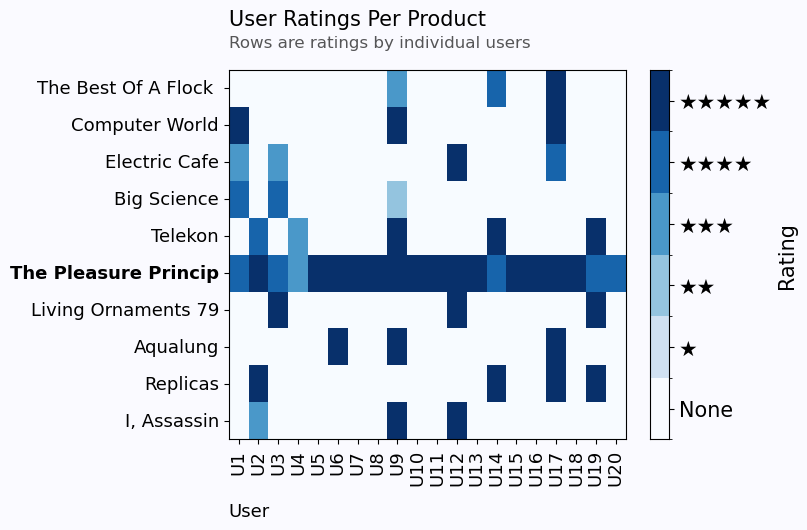

In [37]:

import matplotlib as mpl

user_ratings_per_product.fillna(fill_value, inplace = True)
plot_user_ratings_by_product(user_ratings_per_product, product.id, conn)
plt.gcf().savefig('../images/recommendation-ratings.png', bbox_inches = 'tight')

### Create Pairwise Similarity table

For each pair of products/rows in teh above rating map, find the similarity between the two rows. Output the pairwise similarities in a matrix:

In [38]:
user_ratings_per_product_sparse = sparse.csr_matrix(user_ratings_per_product.fillna(fill_value))
pairwise_cosine_similarities = pairwise_distances(user_ratings_per_product_sparse, metric = 'cosine')
user_ratings_per_product_sparse
pairwise_cosine_similarities = pd.DataFrame(pairwise_cosine_similarities, index = user_ratings_per_product.index, columns = user_ratings_per_product.index)
pairwise_cosine_similarities

product_id,B0000004U8,B000002GYI,B000002GZ4,B000002KNM,B000006NTP,B000006NTW,B0000085CU,B00000GAIW,B00000I2B0,B00006J677
product_id,,,,,,,,,,
B0000004U8,0.000000,0.346803,0.631770,0.858579,0.505025,0.622018,1.000000,0.346803,0.363604,0.723828
B000002GYI,0.346803,0.000000,0.473848,0.422650,0.711325,0.614224,1.000000,0.333333,0.711325,0.624177
B000002GZ4,0.631770,0.473848,0.000000,0.479244,1.000000,0.571263,0.398683,0.699342,0.739622,0.576271
B000002KNM,0.858579,0.422650,0.479244,0.000000,0.833333,0.665908,0.615100,0.807550,1.000000,0.783018
B000006NTP,0.505025,0.711325,1.000000,0.833333,0.000000,0.551362,0.711325,0.711325,0.300000,0.518301
B000006NTW,0.622018,0.614224,0.571263,0.665908,0.551362,0.000000,0.641779,0.586669,0.570453,0.596117
B0000085CU,1.000000,1.000000,0.398683,0.615100,0.711325,0.641779,0.000000,1.000000,0.711325,0.624177
B00000GAIW,0.346803,0.333333,0.699342,0.807550,0.711325,0.586669,1.000000,0.000000,0.711325,0.624177
B00000I2B0,0.363604,0.711325,0.739622,1.000000,0.300000,0.570453,0.711325,0.711325,0.000000,0.804717


product details 10: 10 results in 0.000 seconds


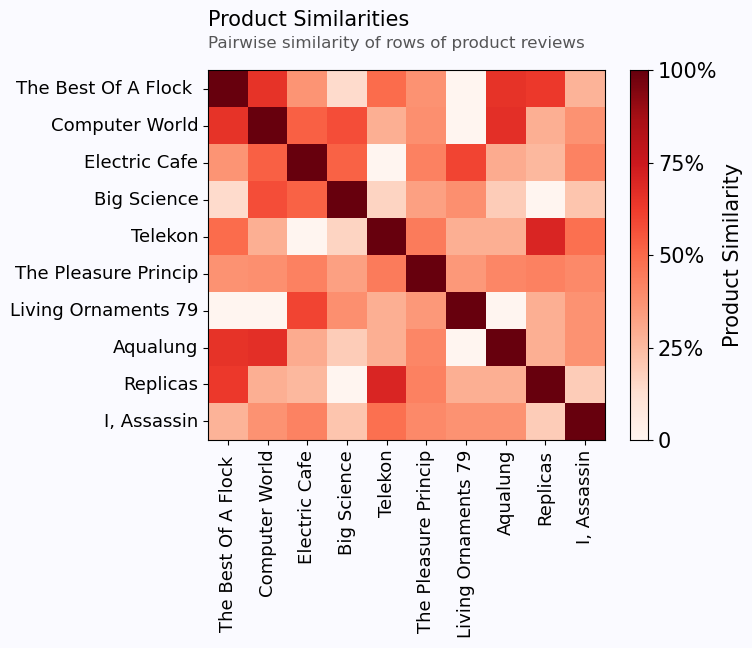

In [39]:
def plot_pairwise_similarities(data: pd.DataFrame, id: str, conn, product_name_limit = 20, ax = None, cbar_kws = None, title_fontsize = 15, cbar_fontsize = 15, axis_fontsize = 13):
    ax = ax or plt.gca()
    ax = sns.heatmap(data, vmin = 0, vmax = 1, cmap = 'Reds', ax = ax, cbar_kws = cbar_kws)
    colorbar = ax.collections[0].colorbar
    colorbar.set_label('Product Similarity', fontsize = cbar_fontsize)
    colorbar.set_ticks([0, .25, .5, .75, 1])
    colorbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'], fontsize = cbar_fontsize)
    for spine in ['top', 'bottom', 'left', 'right']:
        colorbar.ax.spines[spine].set_visible(True)
        ax.spines[spine].set_visible(True)
    product_names = q.get_product_details(data.index, conn, select = 'title')['title']
    product_names = product_names.map(lambda title: title[:product_name_limit])
    ax.xaxis.set_ticklabels(product_names, fontsize = axis_fontsize)
    ax.yaxis.set_ticklabels(product_names, fontsize = axis_fontsize)
    ax.set_title('Product Similarities', fontsize = title_fontsize, loc = 'left')
    add_title_and_subtitle(ax, 'Product Similarities', 'Pairwise similarity of rows of product reviews')
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    return ax

pairwise_similarities = pairwise_cosine_similarities.map(lambda x: 1 - x)
plot_pairwise_similarities(pairwise_similarities, product.id, conn)    
plt.gcf().savefig('../images/recommendation-similarities.png', bbox_inches = 'tight')

Let's put the above two together into a shared plot so we can see the connection:

product details 10: 10 results in 0.001 seconds
product details 10: 10 results in 0.000 seconds


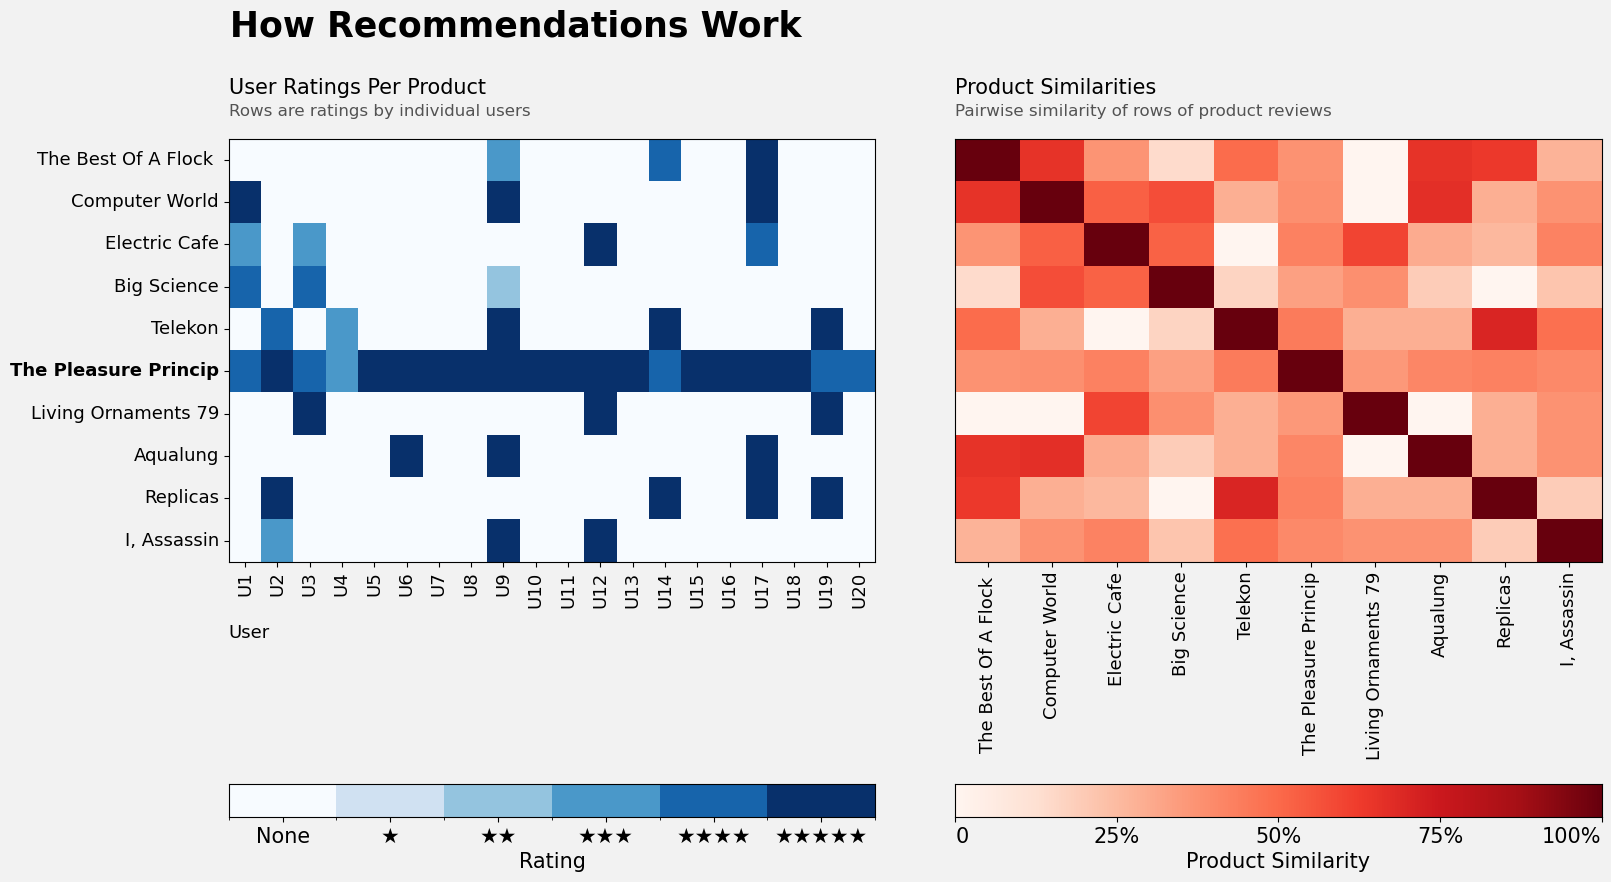

In [40]:

layout = 'constrained'
fig = plt.figure(figsize = (16,8), layout = layout)
fig.set_constrained_layout_pads(wspace = 0.1)
ax_ratings = plt.subplot(121)
plot_user_ratings_by_product(user_ratings_per_product, product.id, conn, cbar_kws={'orientation': 'horizontal'})
ax_similarities = plt.subplot(122)
# for unknnown reasons, thie next line does not work. Let's try a different approach
ax_similarities.yaxis.set_visible(False)
plot_pairwise_similarities(pairwise_similarities, product.id, conn, cbar_kws = {'orientation': 'horizontal'})

colorbar_ratings = ax_ratings.collections[0].colorbar

fig.suptitle('How Recommendations Work', fontsize = 25, fontweight = 'bold', y = 1.08, x = 0.14, horizontalalignment = 'left')
fig.set_facecolor(('k', 0.05))

similarity_color_bar = ax_similarities.collections[0].colorbar
similarity_ticklabels = similarity_color_bar.ax.xaxis.get_ticklabels()
similarity_ticklabels[0].set_horizontalalignment('left')
similarity_ticklabels[-1].set_horizontalalignment('right')

fig.savefig('../images/recommendations.png', bbox_inches = 'tight', transparent = False)

In [41]:
recommendations = pairwise_cosine_similarities.loc[product.id]
results = q.get_recommendations_from_reviews(product.id, related_reviews, conn)
results

0.0074: Created ratings table for 10 products by 20 users
0.00837: Calculated similarities
0.0107: Added product details


,similarity,title,creator,publisher,description,category,subcategory,release_date
B000006NTP,0.448638,Telekon,Gary Numan,,Gary Numan - Telekon - CD,Music,,"December 7, 2006"
B00000I2B0,0.429547,Replicas,Gary Numan,,"Product Description, Original UK Album plus Si...",Music,,"April 30, 2006"
B000002GZ4,0.428737,Electric Cafe,Kraftwerk,,"Product description, 1986 pioneering electroni...",Music,,"December 15, 2006"
B00000GAIW,0.413331,Aqualung,Jethro Tull,,"Product description, Aqualung (Special Edition...",Music,,"July 26, 2006"
B00006J677,0.403883,"I, Assassin",Gary Numan,,"Product description, N/A, Review, Even the mos...",Music,,"February 13, 2007"
B000002GYI,0.385776,Computer World,Kraftwerk,,"Product Description, The surprise album from t...",Music,,"December 16, 2006"
B0000004U8,0.377982,The Best Of A Flock Of Seagulls,Flock Of Seagulls,,"Product description, No Description AvailableN...",Music,,"December 7, 2006"
B0000085CU,0.358221,Living Ornaments 79,Gary Numan,,England.,Music,,"February 19, 2007"
B000002KNM,0.334092,Big Science,Laurie Anderson,,"Amazon.com, Big Science, prompted trendy early...",Music,,"July 27, 2006"
